ZHAW, CAS MAIN, Module Deep Learning  
**Final Project Finn Stein & Severin Trösch, April 2020**

# Predicting Triathlon-Rankings: fcNN (classification & regression)

In this notebook, we aim to predict the ranking of triathlon races using a *fully connected neural network (fcNN)* for regression. The fcNN-ranker should learn on a dataset containing triathlon wordcup-results from 1989 to 2020.  

In the end, we want to compare the quality of this ranker to those of other ranking-algorithms (e.g. RankNet).  

So, let's go :-)

### Import libraries and data

In [0]:
## load required libraries:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('default')
from sklearn.metrics import confusion_matrix
import pandas as pd
import copy

%tensorflow_version 2.x
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Convolution2D, MaxPooling2D, Flatten , Activation
from tensorflow.keras.utils import to_categorical , normalize
from tensorflow.keras import optimizers

# for regression
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

# for ranking-evaluation
from sklearn.metrics import ndcg_score

Using TensorFlow backend.


In [0]:
## load data as pd.df and directly one-hot encode categorical vars
# load df
df1 = pd.read_csv("/content/tri_data_nona_nodnf.csv", sep = ";",   encoding='latin-1')
df1

,subj_id,yob,age_y,nat,gender,race_id,race_venue,race_y,race_m,rank_num
0,2828,1990.0,30.0,SRB,Men,104,Chennai,2020,Feb,1
1,2864,1999.0,21.0,HKG,Men,104,Chennai,2020,Feb,2
2,816,1984.0,36.0,POL,Men,104,Chennai,2020,Feb,4
3,855,1999.0,21.0,KAZ,Men,104,Chennai,2020,Feb,5
4,1586,1997.0,23.0,HKG,Men,104,Chennai,2020,Feb,7
...,...,...,...,...,...,...,...,...,...,...
26036,2896,NaN,NaN,CAN,Women,1455,World,1989,Aug,6
26037,597,1966.0,23.0,CAN,Women,1455,World,1989,Aug,7
26038,3372,1964.0,25.0,GER,Women,1455,World,1989,Aug,8
26039,1964,NaN,NaN,CAN,Women,1455,World,1989,Aug,9


In [0]:
## get a data overview
df1.describe()

,subj_id,yob,age_y,race_id,race_y,rank_num
count,26041.000000,25081.000000,25081.000000,26041.000000,26041.000000,26041.000000
mean,1895.730079,1984.747578,26.054384,706.515687,2010.516301,18.110748
std,1136.906834,7.534797,4.342916,426.801280,5.893738,15.433225
min,1.000000,1957.000000,15.000000,1.000000,1989.000000,1.000000
25%,899.000000,1980.000000,23.000000,353.000000,2007.000000,6.000000
50%,1857.000000,1985.000000,26.000000,663.000000,2011.000000,12.000000
75%,2910.000000,1990.000000,29.000000,1075.000000,2015.000000,28.000000
max,3903.000000,2001.000000,50.000000,1489.000000,2020.000000,70.000000


In [0]:
## transform - one hot encoding of factor-variables
# Get dummies
df1_d = pd.get_dummies(df1, prefix_sep='_', drop_first=True)
print(df1_d.head()) ## ATTENTION: subj_id must be character and thus one-hot encoded?! - this does not happen here, so I must do it manually (with to_categorical below)

   subj_id     yob  age_y  ...  race_m_Nov  race_m_Okt  race_m_Sep
0     2828  1990.0   30.0  ...           0           0           0
1     2864  1999.0   21.0  ...           0           0           0
2      816  1984.0   36.0  ...           0           0           0
3      855  1999.0   21.0  ...           0           0           0
4     1586  1997.0   23.0  ...           0           0           0

[5 rows x 347 columns]


In [0]:
df1_d

,subj_id,yob,age_y,race_id,race_y,rank_num,nat_ALG,nat_ARG,nat_ARU,nat_AUS,nat_AUT,nat_AZE,nat_BAR,nat_BEL,nat_BER,nat_BLR,nat_BOL,nat_BRA,nat_BRN,nat_CAN,nat_CHI,nat_CHN,nat_COK,nat_COL,nat_CRC,nat_CRO,nat_CUB,nat_CZE,nat_DEN,nat_DOM,nat_ECU,nat_EGY,nat_ENG,nat_ESA,nat_ESP,nat_EST,nat_FIN,nat_FRA,nat_GBR,nat_GEO,...,race_venue_SÃ¤ter,race_venue_Taizhou,race_venue_TiszaÃºjvÃ¡ros,race_venue_Tokyo,race_venue_Tongyeong,"race_venue_Toronto,",race_venue_Troutbeck,"race_venue_Tuscaloosa,",race_venue_Valencia,race_venue_Valle,race_venue_ValparaÃ­so,race_venue_Vancouver,race_venue_Varna,race_venue_Vienna,race_venue_ViÃ±a,"race_venue_Washington,",race_venue_Weert,race_venue_Weihai,race_venue_Weiswampach,race_venue_Wellington,"race_venue_Whistler,",race_venue_Wilkes,race_venue_World,race_venue_Yamaguichi,race_venue_Yicheng,race_venue_Yilan,race_venue_Yokohama,race_venue_Zhenjiang,race_venue_Zurich,race_m_Aug,race_m_Dez,race_m_Feb,race_m_Jan,race_m_Jul,race_m_Jun,race_m_Mai,race_m_MÃ¤r,race_m_Nov,race_m_Okt,race_m_Sep
0,2828,1990.0,30.0,104,2020,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,2864,1999.0,21.0,104,2020,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,816,1984.0,36.0,104,2020,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,855,1999.0,21.0,104,2020,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,1586,1997.0,23.0,104,2020,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26036,2896,NaN,NaN,1455,1989,6,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
26037,597,1966.0,23.0,1455,1989,7,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
26038,3372,1964.0,25.0,1455,1989,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
26039,1964,NaN,NaN,1455,1989,9,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [0]:
## handle NaNs
df1_d.isnull().any() # there are nans - which is a problem for the net... if NaNs are present - models dont train!

# so fill the NaNs
df1_d_nona = df1_d.interpolate(method='linear', limit_direction='forward', axis=0) # just brutely fill with 0s. better: df.interpolate(method='linear', limit_direction='forward', axis=0)
df1_d_nona.isnull().any() # ok

subj_id        False
yob            False
age_y          False
race_id        False
race_y         False
               ...  
race_m_Mai     False
race_m_MÃ¤r    False
race_m_Nov     False
race_m_Okt     False
race_m_Sep     False
Length: 347, dtype: bool

In [0]:
## and transform to nparray
dat_n = df1_d_nona.values #this is the nparray-form of the data
print(dat_n.shape)
print(dat_n)

(26041, 347)
[[2828. 1990.   30. ...    0.    0.    0.]
 [2864. 1999.   21. ...    0.    0.    0.]
 [ 816. 1984.   36. ...    0.    0.    0.]
 ...
 [3372. 1964.   25. ...    0.    0.    0.]
 [1964. 1964.   25. ...    0.    0.    0.]
 [2238. 1964.   25. ...    0.    0.    0.]]


In [0]:
dat_n[:,5] # col 5 is the rank-column (Y)

array([ 1.,  2.,  4., ...,  8.,  9., 10.])

In [0]:
## now shuffle the data - for fair devision in train, val and test
np.random.seed(666)

dat_sh = copy.copy(dat_n)
#np.random.shuffle(dat_sh) #------------------------------------------------------- shuffeling must be skipped here - otherwise the evaluation with NDCG is not possible (at least how I do it)

dat_sh.shape

(26041, 347)

In [0]:
## one-hot encode subj_id and race_id columns, as these are also categorical (but are not recognised as such by pd above)

subj_arr = to_categorical(dat_sh[:,0]) #subj_id column
print(subj_arr.shape)

race_arr = to_categorical(dat_sh[:,3]) #race_id column
print(race_arr.shape)

(26041, 3904)
(26041, 1490)


In [0]:
## merge subj_id one-hot-matrix with rest of array

# first delete the old col
dat_n_0 = np.delete(dat_sh, [0,3,5], 1)  # delete first and the 4th column of dat_n, as well as the labels (col 5)

# then merge
np_n_1 = np.concatenate((dat_n_0, subj_arr, race_arr), axis=1)

print(dat_n.shape)
print(subj_arr.shape)
print(race_arr.shape)
print(np_n_1.shape) # seems correct (347 + 3904 + 1490 - 3 = 5738) - this is the one-hot encoded, non-normalised input data

(26041, 347)
(26041, 3904)
(26041, 1490)
(26041, 5738)


In [0]:
## normalize input-data
dat_sh_n = normalize(np_n_1)
#help(normalize)

In [0]:
## check - looks ok
print(dat_sh_n.shape)
print(dat_sh[:,1]) #yob
print(dat_sh_n[:,0]) #column with yob
print(np.nanmax(dat_sh[:,1])) #yob

(26041, 5738)
[1990. 1999. 1984. ... 1964. 1964. 1964.]
[0.70175757 0.703383   0.700664   ... 0.7025924  0.7025924  0.7025924 ]
2001.0


In [0]:
## and split X and Y - normalised and non-normalised

X = np_n_1 # the one-hot encoded inputs
Xnorm = dat_sh_n # the one-hot and normalised input-variables
Y = dat_sh[:,5] #the non-ohe-hot Y
Y_oh = to_categorical(dat_sh[:,5]) # col 5 is the rank-column (Y) - this is being one-hot encoded here


# check shapes
print(X.shape)
print(Xnorm.shape)
print(Y.shape)
print(Y_oh.shape)
print()

print(X)
print(Xnorm)
print()
print(Y)
print(Y_oh)

(26041, 5738)
(26041, 5738)
(26041,)
(26041, 71)

[[1990.   30. 2020. ...    0.    0.    0.]
 [1999.   21. 2020. ...    0.    0.    0.]
 [1984.   36. 2020. ...    0.    0.    0.]
 ...
 [1964.   25. 1989. ...    0.    0.    0.]
 [1964.   25. 1989. ...    0.    0.    0.]
 [1964.   25. 1989. ...    0.    0.    0.]]
[[0.70175757 0.01057926 0.71233683 ... 0.         0.         0.        ]
 [0.703383   0.00738922 0.71077221 ... 0.         0.         0.        ]
 [0.700664   0.01271366 0.71337767 ... 0.         0.         0.        ]
 ...
 [0.7025924  0.00894339 0.71153578 ... 0.         0.         0.        ]
 [0.7025924  0.00894339 0.71153578 ... 0.         0.         0.        ]
 [0.7025924  0.00894339 0.71153578 ... 0.         0.         0.        ]]

[ 1.  2.  4. ...  8.  9. 10.]
[[0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [0]:
## generate train, val and test-set
X_val, X_test, X_train = X[0:1000], X[1000:2000], X[2000:]
Y_val, Y_test, Y_train = Y[0:1000], Y[1000:2000], Y[2000:]
Y_oh_val, Y_oh_test, Y_oh_train = Y_oh[0:1000], Y_oh[1000:2000], Y_oh[2000:]

# and for the normalsied data
X_val_norm, X_test_norm, X_train_norm = Xnorm[0:1000], Xnorm[1000:2000], Xnorm[2000:]

# check shapes
print(X_val.shape, X_test.shape, X_train.shape, ' ... the non-normalised inputs')
print(X_val_norm.shape, X_test_norm.shape, X_train_norm.shape,  ' ... the normalised inputs')
print()
print(Y_val.shape, Y_test.shape, Y_train.shape, ' ... the non-one-hot labels')
print(Y_oh_val.shape, Y_oh_test.shape, Y_oh_train.shape, ' ... the one-hot labels')

(1000, 5738) (1000, 5738) (24041, 5738)  ... the non-normalised inputs
(1000, 5738) (1000, 5738) (24041, 5738)  ... the normalised inputs

(1000,) (1000,) (24041,)  ... the non-one-hot labels
(1000, 71) (1000, 71) (24041, 71)  ... the one-hot labels


## Intermezzo: Build and fit a *classification* net 

We now have generated and pre-processed tha dataset. So now, let's build a neural net.

First, let's try a normal classification setup (in the end we aim for a regression - so just out of curiosity...):

In [0]:
# define fcNN classifier
model = Sequential()

model.add(Dense(256, batch_input_shape=(None, 5738)))
model.add(Activation('relu'))

# go a little bit deep
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dense(256))
model.add(Activation('relu'))

model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dense(128))
model.add(Activation('relu'))

# for one-hot encoded labels
model.add(Dense(71)) # ----------------------------------- here - when net is classification - same shape as output is needed (71)
model.add(Activation('relu')) # try relu and softmax here

# compile model
myadam = optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False) #default lr = 0.001

model.compile(loss='categorical_crossentropy', 
              optimizer=myadam,     
              metrics=['accuracy'])

In [0]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_88 (Dense)             (None, 256)               1469184   
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dense_89 (Dense)             (None, 256)               65792     
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dense_90 (Dense)             (None, 256)               65792     
_________________________________________________________________
activation_2 (Activation)    (None, 256)               0         
_________________________________________________________________
dense_91 (Dense)             (None, 128)             

In [0]:
## train the model
np.random.seed(11)
history=model.fit(X_train_norm, Y_oh_train, # try also Y_train here (non-one-hot)
                  batch_size=128, 
                  epochs=100,
                  verbose=2,   
                  validation_data=(X_val_norm, Y_oh_val)
                 )

## goodness! the accuracy is lousy!

Epoch 1/100
188/188 - 5s - loss: 8.0766 - accuracy: 0.0482 - val_loss: 7.6004 - val_accuracy: 0.0350
Epoch 2/100
188/188 - 5s - loss: 7.7973 - accuracy: 0.0517 - val_loss: 7.6142 - val_accuracy: 0.0350
Epoch 3/100
188/188 - 5s - loss: 7.8422 - accuracy: 0.0484 - val_loss: 7.6085 - val_accuracy: 0.0350
Epoch 4/100
188/188 - 5s - loss: 7.8430 - accuracy: 0.0497 - val_loss: 7.6212 - val_accuracy: 0.0330
Epoch 5/100
188/188 - 5s - loss: 7.8429 - accuracy: 0.0490 - val_loss: 7.6104 - val_accuracy: 0.0350
Epoch 6/100
188/188 - 5s - loss: 7.8423 - accuracy: 0.0501 - val_loss: 7.6126 - val_accuracy: 0.0330
Epoch 7/100
188/188 - 5s - loss: 7.8424 - accuracy: 0.0497 - val_loss: 7.6188 - val_accuracy: 0.0310
Epoch 8/100
188/188 - 5s - loss: 7.8419 - accuracy: 0.0500 - val_loss: 7.6174 - val_accuracy: 0.0330
Epoch 9/100
188/188 - 5s - loss: 7.8416 - accuracy: 0.0488 - val_loss: 7.6187 - val_accuracy: 0.0350
Epoch 10/100
188/188 - 5s - loss: 6.8958 - accuracy: 0.0485 - val_loss: 6.4938 - val_accura

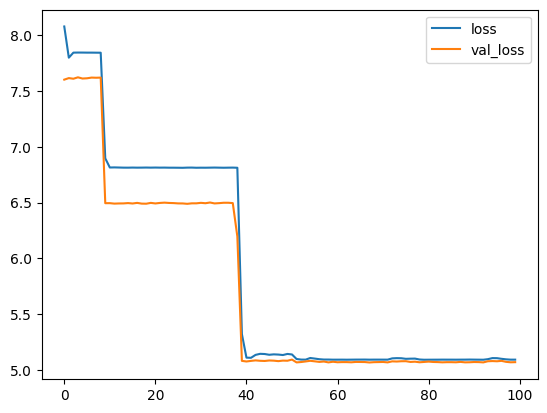

In [0]:
## and plot odd-looking loss-curves
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

**Note:**

The accuracy of the classification is pretty lousy: We have ~ 17.5 athletes per race on average. So if we guessed the rank of an athlete at random we would expect a chance of success of 1/17.5 = 0.057. The fcNN classifier barely beats that...

However, we didn't want to do classification anyway...

End of intermezzo :-)

## Now, the real stuff: A regression-fcNN

From the homepage:

https://machinelearningmastery.com/regression-tutorial-keras-deep-learning-library-python/

We can create Keras models and evaluate them with scikit-learn by using handy wrapper objects provided by the Keras library. This is desirable, because scikit-learn excels at evaluating models and will allow us to use powerful data preparation and model evaluation schemes with very few lines of code.

The Keras wrappers require a function as an argument. This function that we must define is responsible for creating the neural network model to be evaluated.

Build the regresssion-dataset:

In [0]:
# the label-col
dat_sh[:,5]

array([ 1.,  2.,  4., ...,  8.,  9., 10.])

In [0]:
## the regression inputs and labels
Xreg = np.delete(dat_sh, 5, 1) #delete labels
print(Xreg.shape)

print(Y.shape) # is this ok? or should it be (26041,1)?

(26041, 346)
(26041,)


In [0]:
## quickly check if there is a col with just zeros

nullen = 0

for i in range(Xreg.shape[1]):
  if np.sum(Xreg[:,i]) == 0:
    nullen += 1

print(nullen)
# no

0


In [0]:
# ## build train / test for the regression
# xr_train, xr_test, yr_train, yr_test = train_test_split(Xreg, Y, test_size=0.25, random_state=42)

# print(xr_train.shape, xr_test.shape)
# print(yr_train.shape, yr_test.shape)

In [0]:
## build train / test for the regression - in same manner as for the RankNet in other notebook

xr_val, xr_test, xr_train  = Xreg[0:1000], Xreg[1000:2000], Xreg[2000:]
yr_val, yr_test, yr_train = Y[0:1000], Y[1000:2000], Y[2000:]

print(xr_train.shape, xr_test.shape)
print(yr_train.shape, yr_test.shape)

(24041, 346) (1000, 346)
(24041,) (1000,)


The regression-model:

In [0]:
## regression in form found online

#define base model

def baseline_model():
  # create model
  model = Sequential()

  model.add(Dense(100, input_dim=346, kernel_initializer='normal', activation='relu'))
  
  ## Make it deep here!
  model.add(Dense(256,activation="relu",kernel_initializer='normal'))
  model.add(Dense(256,activation="relu",kernel_initializer='normal'))
  model.add(Dense(256,activation="relu",kernel_initializer='normal'))
  model.add(Dense(128,activation="relu",kernel_initializer='normal'))
  model.add(Dense(128,activation="relu",kernel_initializer='normal'))
  model.add(Dense(128,activation="relu",kernel_initializer='normal'))

  model.add(Dense(1, kernel_initializer='normal')) #
  # Compile model
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model

In [0]:
baseline_model().summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_94 (Dense)             (None, 100)               34700     
_________________________________________________________________
dense_95 (Dense)             (None, 256)               25856     
_________________________________________________________________
dense_96 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_97 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_98 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_99 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_100 (Dense)            (None, 128)             

In [0]:
# build estimator and prepare cross-validation
epochs_ = 15 #15 in the end

estimator = KerasRegressor(build_fn=baseline_model, epochs=epochs_, batch_size=5, verbose=2, validation_data = (xr_test,yr_test)) # pass validation data here! 

kfold = KFold(n_splits=10)

In [0]:
# # now train and cross-evaluate - what for exactly?
# results = cross_val_score(estimator, Xreg, Y, cv=kfold) #X-input is the non-one-hot data frame...
# print("Baseline: %.2f (%.2f) MSE" % (results.mean(), results.std()))

In [0]:
## fit the thing
history_deep = estimator.fit(xr_train, yr_train)

Epoch 1/15
4809/4809 - 13s - loss: 253.6690 - val_loss: 183.8065
Epoch 2/15
4809/4809 - 13s - loss: 246.9937 - val_loss: 192.3219
Epoch 3/15
4809/4809 - 13s - loss: 245.6243 - val_loss: 191.0753
Epoch 4/15
4809/4809 - 13s - loss: 243.3901 - val_loss: 185.9036
Epoch 5/15
4809/4809 - 13s - loss: 242.1051 - val_loss: 179.8103
Epoch 6/15
4809/4809 - 13s - loss: 238.6709 - val_loss: 177.5127
Epoch 7/15
4809/4809 - 13s - loss: 228.5749 - val_loss: 172.5075
Epoch 8/15
4809/4809 - 13s - loss: 216.8304 - val_loss: 165.5019
Epoch 9/15
4809/4809 - 14s - loss: 213.5659 - val_loss: 188.4324
Epoch 10/15
4809/4809 - 13s - loss: 211.2529 - val_loss: 187.5015
Epoch 11/15
4809/4809 - 13s - loss: 205.7859 - val_loss: 159.6856
Epoch 12/15
4809/4809 - 13s - loss: 205.6831 - val_loss: 205.3488
Epoch 13/15
4809/4809 - 13s - loss: 202.6225 - val_loss: 173.4026
Epoch 14/15
4809/4809 - 14s - loss: 201.4252 - val_loss: 189.1519
Epoch 15/15
4809/4809 - 13s - loss: 198.4151 - val_loss: 181.9796


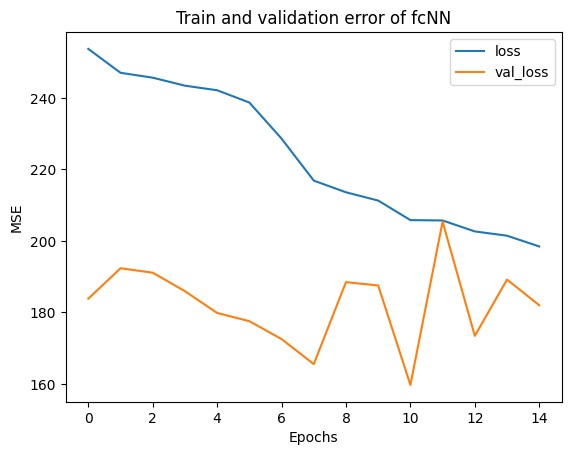

In [0]:
## plot loss
plt.plot(history_deep.history['loss'])
plt.plot(history_deep.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylabel('MSE')
plt.xlabel('Epochs')
#plt.ylim(2,6)
plt.title('Train and validation error of fcNN')
plt.show()

In [0]:
## predict whole set
prediction = estimator.predict(xr_test) 

200/200 - 0s


In [0]:
print(prediction.shape)
print(prediction[:10])
print(Y[:10])

(1000,)
[18.945251 20.120827 15.884424 15.682125 18.951622 18.77377  14.515133
 22.963737 15.419075 19.015291]
[ 1.  2.  4.  5.  7.  8.  9. 10. 11. 12.]


In [0]:
## get mean loss
estimator.score(xr_test,yr_test) #mean loss - these are "squared ranks"

200/200 - 0s - loss: 181.9796


-181.97958374023438

### Performance evaluation and comparison

Used metric: NDCG

Text(0.5, 0, 'true labels (rank)')

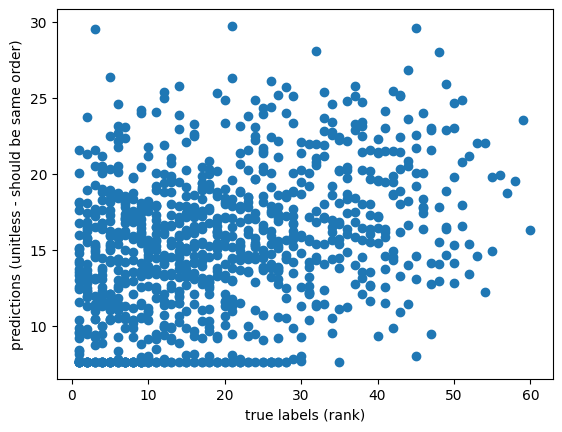

In [0]:
## plot the prediction - and compare the sorting to the labels (should correlate...)
plt.scatter(yr_test, prediction)
plt.ylabel("predictions (unitless - should be same order)")
plt.xlabel("true labels (rank)")
#plt.title("Predicted vs. true ranks for race ID = {}".format(raceid))

In [0]:
## understand function
help(ndcg_score)

In [0]:
# ## define a function that caltulates the NDCG for the ranking of test set...

# def get_ndcg(true_ranks, input_data):
#   '''
#   Compute Normalized Discounted Cumulative Gain:
#       Sum the true scores ranked in the order induced by the predicted scores, after applying a logarithmic discount. 
#       Then divide by the best possible score (Ideal DCG, obtained for a perfect ranking) to obtain a score between 0 and 1.

#   true_ranks = array of ranking labels
#   input_data = array of input features with which esimator predicts ranking
#   '''
#   # we have groud-truth relevance of some answers to a query:
#   true_relevance = [true_ranks.tolist()]

#   # we predict some scores (relevance) for the answers
#   scores = [estimator.predict(input_data).tolist()] #???
  
#   return ndcg_score(true_relevance, scores)

In [0]:
## define a function that caltulates the NDCG for the ranking of test set (devided by qid)...

def get_ndcg_filt(true_ranks, input_data, qid):
  '''
  Compute Normalized Discounted Cumulative Gain:
      Sum the true scores ranked in the order induced by the predicted scores, after applying a logarithmic discount. 
      Then divide by the best possible score (Ideal DCG, obtained for a perfect ranking) to obtain a score between 0 and 1.
  
  inputs:
    true_ranks = array of ranking labels (not filtered by id)
    input_data = array of input features with which esimator predicts ranking (not filtered by id)
    qid = array of race ids in input_data (to filter with)

  return: 
    list of NDCGs for the input - by qid (take mean of this after)
  '''
  #prepare list
  res = []

  # build a loop
  for race_id in np.unique(qid):

    # first, build the race_id filter
    linefilter = input_data[:,3] == race_id
    #filtered =  input_data[linefilter,3] #input data with only race-id
    
    # we filter and get groud-truth relevance of some answers to a query:
    true_ranks_f = true_ranks[linefilter]
    true_relevance = [true_ranks_f.tolist()]
    
    # we filter and predict some scores (relevance) for the answers
    input_data_f = input_data[linefilter]
    scores = [estimator.predict(input_data_f).tolist()]

    #calculate ndcg
    ndcg = ndcg_score(true_relevance, scores)

    # append to list
    res.append(ndcg)
  
  return res

In [0]:
## define the "query-id" - for us, this is the race id (Query id that represents the grouping of samples.)
qidr_test = xr_test[:,3] # race ids from test set
qidr_train = xr_train[:,3] # race ids from test set

qidr_train = qidr_train.astype('int') # change dtype, must be 'int'
print(qidr_train.shape)

qidr_test = qidr_test.astype('int') # change dtype, must be 'int'
print(qidr_test.shape)

(24041,)
(1000,)


In [0]:
np.unique(qidr_test)

array([   9,   19,  133,  138,  207,  227,  230,  252,  316,  352,  409,
        434,  532,  533,  561,  581,  595,  629,  682,  704,  743,  754,
        764,  877,  882,  952,  972,  975,  997, 1096, 1154, 1179, 1276,
       1277, 1305, 1324, 1339, 1373, 1426, 1448, 1487])

In [0]:
## get test ndcg
test_ndcgs = get_ndcg_filt(yr_test,xr_test,qidr_test)

6/6 - 0s
9/9 - 0s
9/9 - 0s
4/4 - 0s
10/10 - 0s
6/6 - 0s
6/6 - 0s
9/9 - 0s
6/6 - 0s
5/5 - 0s
2/2 - 0s
11/11 - 0s
11/11 - 0s
4/4 - 0s
5/5 - 0s
3/3 - 0s
3/3 - 0s
10/10 - 0s
8/8 - 0s
8/8 - 0s
7/7 - 0s
2/2 - 0s
3/3 - 0s
4/4 - 0s
1/1 - 0s
8/8 - 0s
6/6 - 0s
3/3 - 0s
6/6 - 0s
2/2 - 0s
1/1 - 0s
4/4 - 0s
6/6 - 0s
2/2 - 0s
3/3 - 0s
2/2 - 0s
2/2 - 0s
5/5 - 0s
6/6 - 0s
5/5 - 0s
8/8 - 0s


In [0]:
## mean of test ndcg - this is what we want to compare
np.mean(test_ndcgs)

0.8449628433825819

Compare the performance to a random orfdering of same length (as NDCG depends on length itself):

In [0]:
## find out how many athletes per race in test set
len(qidr_test) / len(np.unique(qidr_test))

24.390243902439025

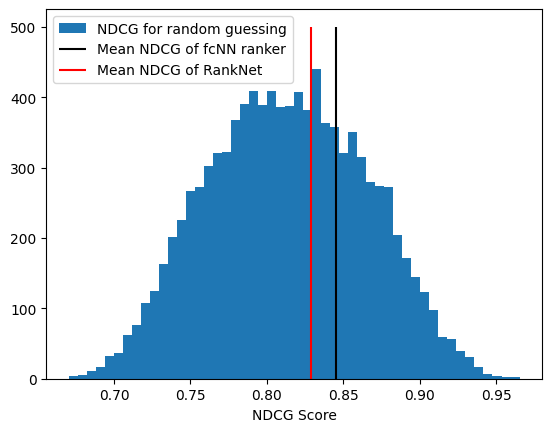

In [0]:
## for comparison: ndcg for random sampling
random_ndcgs = []
nitems = 25 #the average race in the test set has 24.4 athletes to order

ranknet_ndcg = 0.8289096375321607 # test performance for shuffled data (!) from other script (see also comments there)

np.random.seed(11)

for i in range(10000):
  labs = [np.arange(nitems).tolist()]
  rand = [np.random.uniform(0,10,nitems).tolist()]
  random_ndcgs.append(ndcg_score(labs, rand))

plt.hist(random_ndcgs, bins = 50, label="NDCG for random guessing")
plt.vlines(np.mean(test_ndcgs), 0,500, label="Mean NDCG of fcNN ranker")
plt.vlines(ranknet_ndcg, 0,500, label="Mean NDCG of RankNet", color = "red") # from other script
plt.xlabel("NDCG Score")

plt.legend()

**Note:**

* A *random* list (length = 25) seems to have a NDCG of 0.75 to 0.85. 
* Also, NDCG at random seems to be higher if only the number of items to sort grows (for length = 10000 random items the NDCG ist around .93!)